In [98]:
import parser
import json
import urllib
import pandas as pd
import imp
import numpy as np
import seaborn as sns
from tqdm import tqdm
import math

from sklearn.impute import SimpleImputer
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from PIL import Image
import matplotlib.pyplot as plt
import imdb_movie_content
from collections import Counter
%matplotlib inline
imp.reload(parser)
imp.reload(imdb_movie_content)

<module 'imdb_movie_content' from 'c:\\Users\\Rohit Bhadauria\\Pictures\\Data-Science-Projects\\ProjectMovieRating\\imdb_movie_content.py'>

In [99]:
df = parser.create_dataframe("movie_contents.json", "movie_budget.json")
df.set_index('movie_title', inplace=True, drop=False)
df.sort_index(inplace=True)

awards_columns = [col for col in df.columns if 'nominated' in col or 'won' in col]
df_awards = df[awards_columns]
awards_per_movie = (len(awards_columns) - df_awards.isnull().sum(axis=1)).to_dict()
df['nb_awards'] = df['movie_title'].map(awards_per_movie)
df = df.drop_duplicates(['movie_title'])
df = df.rename(columns = {'director_fb_links': 'director_fb_likes'})


## Awards and Gross

In [114]:
#df.head()


,title_year,storyline,contentRating,movie_imdb_link,color,country,keywords,num_voted_users,duration_sec,num_critic_for_reviews,...,Golden Globe_nominated_15,Golden Globe_nominated_16,BAFTA Film Award_won_5,BAFTA Film Award_nominated_10,BAFTA Film Award_won_6,BAFTA Film Award_nominated_11,Oscar_nominated_11,BAFTA Film Award_won_7,BAFTA Film Award_won_8,nb_awards
movie_title,,,,,,,,,,,,,,,,,,,,,
The Shawshank Redemption,1994,Chronicles the experiences of a formerly succe...,R,http://www.imdb.com/title/tt0111161/,Color,USA,prison|wrongful imprisonment|escape from priso...,None,8520.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


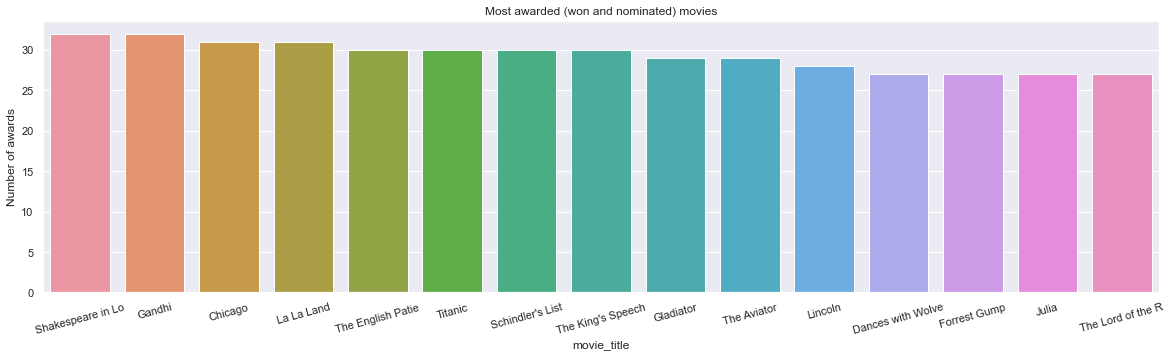

In [46]:
d = df['nb_awards'].sort_values(ascending=False)[:15]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Most awarded (won and nominated) movies')
_ = plot.set_ylabel('Number of awards')

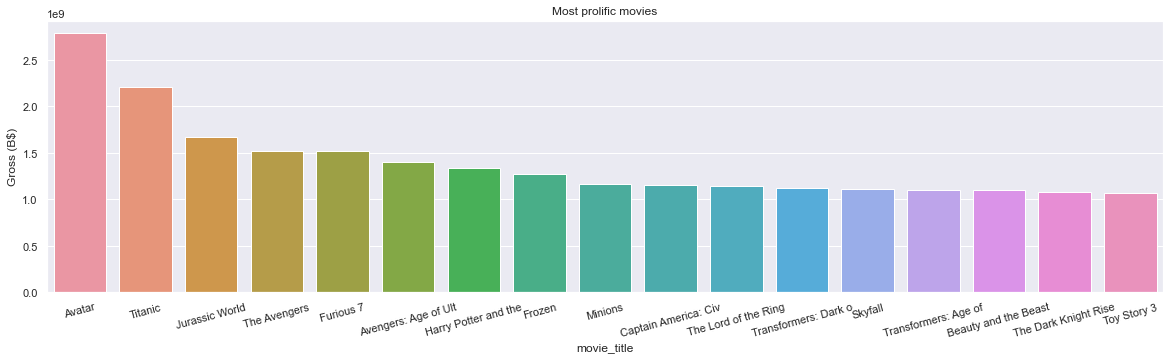

In [47]:
d = df.worldwide_gross.sort_values(ascending=False)[:17]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:20] for elem in d.index], rotation=15)
_ = plot.set_title('Most prolific movies')
_ = plot.set_ylabel('Gross (B$)')

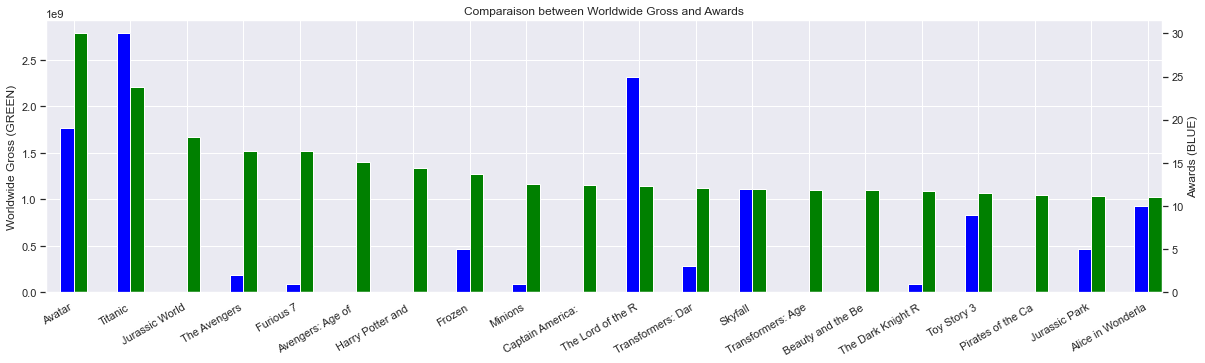

In [48]:
sns.set()

d = df.worldwide_gross.sort_values(ascending=False)[:20]
e = df_awards[df_awards.index.isin(d.index)].isnull().sum(axis=1)
e = len(awards_columns) - e[~e.index.duplicated(keep='first')].reindex(d.index)

margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross (GREEN)')
ax2.set_ylabel('Awards (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and Awards')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Facebook likes

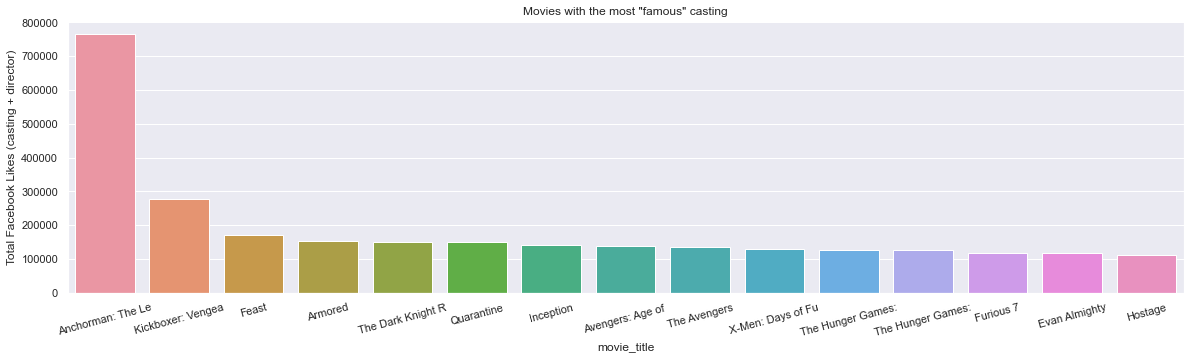

In [49]:
d = df['total_cast_fb_likes'].sort_values(ascending=False)[:15]
e = df[df.index.isin(d.index)].num_facebook_like
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Movies with the most "famous" casting')
_ = plot.set_ylabel('Total Facebook Likes (casting + director)')

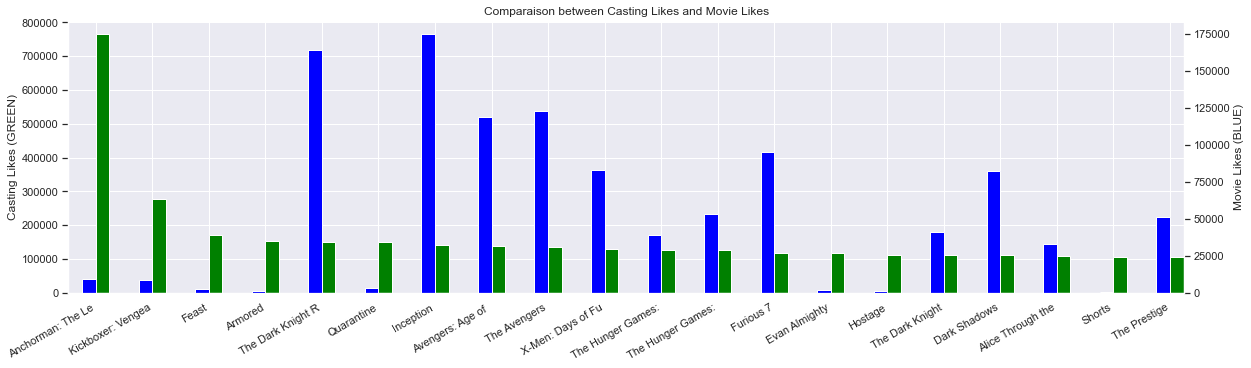

In [50]:
sns.set()

d = df['total_cast_fb_likes'].sort_values(ascending=False)[:20]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Casting Likes (GREEN)')
ax2.set_ylabel('Movie Likes (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Casting Likes and Movie Likes')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Best Actors

### Actor in movie

In [51]:
all_actors = [actor for actor in list(set(list(df.actor_1_name) + list(df.actor_2_name) + list(df.actor_3_name))) if pd.notnull(actor)]
imdb_score_per_actor = {}
for actor in all_actors:
    imdb_score_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].idmb_score.mean()

In [52]:
millnames = ['',' K',' M',' B']
def millify(n):
    if pd.notnull(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    else:
        return n

In [53]:
gross_per_actor = {}
for actor in all_actors:
    gross_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].worldwide_gross.mean()

In [54]:
mini_movie = 3
top_k = 3
best_mini_gross = sorted([(k,v) for k,v in sorted(gross_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == k) 
                                                                                                           | (df.actor_2_name == k) 
                                                                                                           | (df.actor_3_name == k)]) >= mini_movie], key=lambda x:x[1], reverse=True)[:20]

best_mini_gross_str = [elem[0]+ ', %s (%s movie.s)' % (millify(elem[1]),len(df[(df.actor_1_name == elem[0]) 
                                                   | (df.actor_2_name == elem[0]) 
                                                   | (df.actor_3_name == elem[0])])) for elem in best_mini_gross][:top_k]

best_mini = [(k,v) for k,v in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == k) 
                                                                                                   | (df.actor_2_name == k) 
                                                                                                   | (df.actor_3_name == k)]) >= mini_movie][:20]

best_mini_str = [elem[0]+ ', %s (%s movies)' % (round(elem[1], 2),len(df[(df.actor_1_name == elem[0]) 
                                                   | (df.actor_2_name == elem[0]) 
                                                   | (df.actor_3_name == elem[0])])) for elem in best_mini][:top_k]

In [55]:
print('The {} best actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_str)))

print('\nThe {} most prolific actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini_gross_str)))

The 3 best actors are (with minimum 3 movies) : 
Mark Hamill, 8.63 (3 movie.s)
Richard Attenborough, 8.03 (3 movie.s)
Gene Wilder, 7.87 (3 movie.s)

The 3 most prolific actors are (with minimum 3 movies) : 
Sam Worthington, 1.0 B (3 movie.s)
Daniel Radcliffe, 876.9 M (4 movie.s)
Richard Armitage, 825.8 M (4 movie.s)


C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


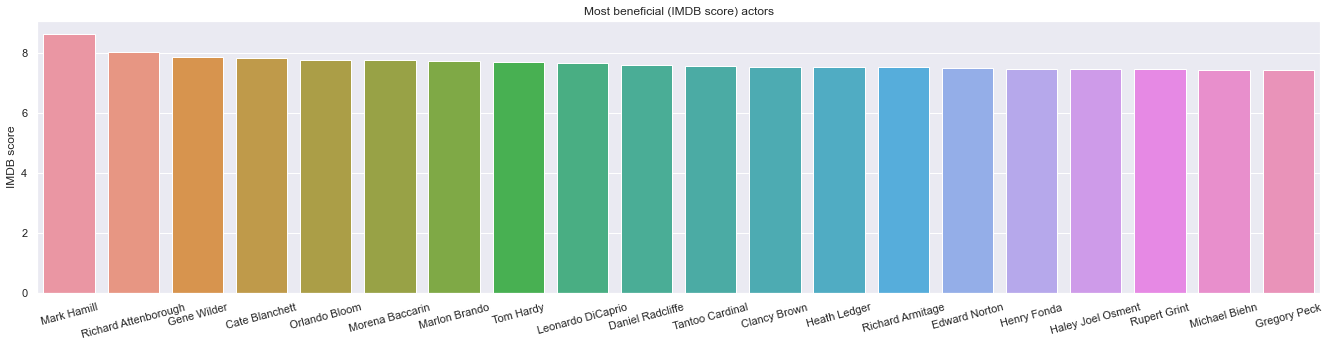

In [56]:
plt.figure(figsize=(23,5))

plot = sns.barplot([elem[0] for elem in best_mini], [elem[1] for elem in best_mini])
_ = plot.set_xticklabels([elem[0] for elem in best_mini], rotation=15)
_ = plot.set_title('Most beneficial (IMDB score) actors')
_ = plot.set_ylabel('IMDB score')

C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


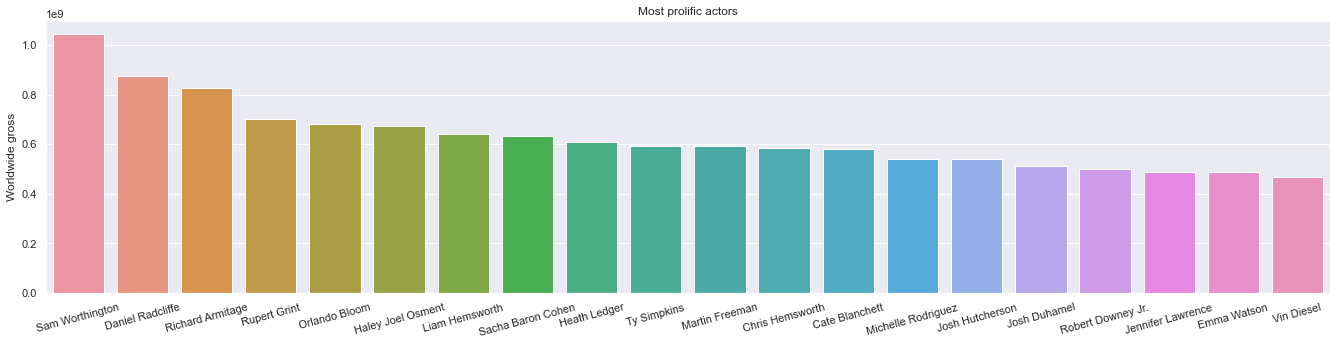

In [57]:
plt.figure(figsize=(23,5))
plot = sns.barplot([elem[0] for elem in best_mini_gross], [elem[1] for elem in best_mini_gross])
_ = plot.set_xticklabels([elem[0] for elem in best_mini_gross], rotation=15)
_ = plot.set_title('Most prolific actors')
_ = plot.set_ylabel('Worldwide gross')

### First star in movie

In [58]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} best actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 best actors as most famous actor are :


C:\Users\ROHITB~1\AppData\Local\Temp/ipykernel_9944/3404897590.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Gene Wilder,7.866667,69.9 M,3
Richard Armitage,7.733333,977.5 M,3
Benedict Cumberbatch,7.700000,347.6 M,3
Matthew McConaughey,7.675000,213.4 M,4
Leonardo DiCaprio,7.661538,300.4 M,13
Tom Hanks,7.483333,318.5 M,12
Tom Hardy,7.483333,277.9 M,6


In [59]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} most prolific actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 most prolific actors as most famous actor are :


C:\Users\ROHITB~1\AppData\Local\Temp/ipykernel_9944/3792525479.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Richard Armitage,7.733333,977.5 M,3
Sean Bean,7.033333,598.7 M,3
Chris Hemsworth,6.950000,585.1 M,8
Sacha Baron Cohen,6.966667,578.0 M,3
Christopher Lee,6.640000,557.7 M,5
Jennifer Lawrence,7.118182,489.0 M,11
Robert Pattinson,5.866667,481.8 M,6


## IMDB rating and other variables

Text(0.5, 1.0, 'Gross and Movie Likes compared to IMDB score')

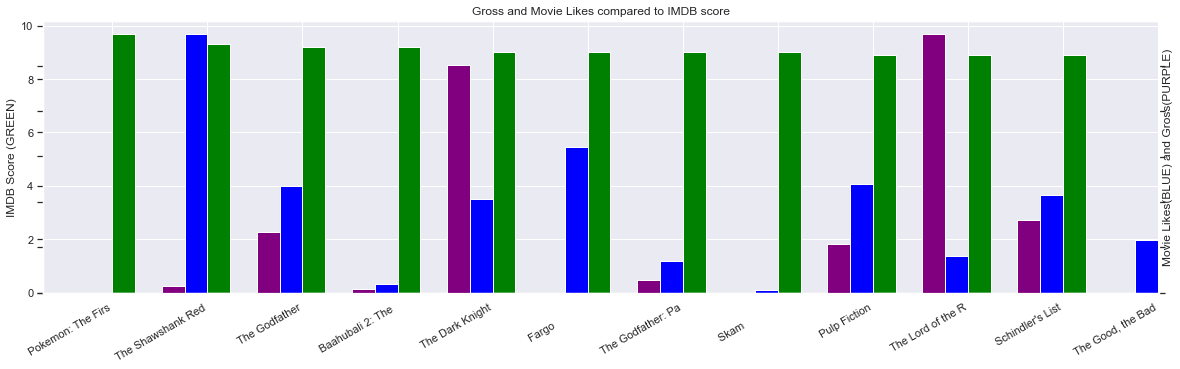

In [60]:
d = df['idmb_score'].apply(float).sort_values(ascending=False)[:12]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
f = df[df.index.isin(d.index)].worldwide_gross.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3= ax2.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
f.plot(kind='bar', color='purple', ax=ax3, width=width, position=2)
ax.set_ylabel('IMDB Score (GREEN)')
ax2.set_ylabel('Movie Likes(BLUE) and Gross(PURPLE)')
ax3.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xlabel('')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax3.grid(False)
ax2.grid(False)
ax.set_title('Gross and Movie Likes compared to IMDB score')

C:\Users\ROHITB~1\AppData\Local\Temp/ipykernel_9944/3348003626.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),


,nb_awards,domestic_gross,worldwide_gross,total_cast_fb_likes,director_fb_likes,production_budget,num_critic_for_reviews,idmb_score,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes
nb_awards,1.000000,0.264630,0.237191,0.114242,0.240809,0.071708,0.261132,0.382991,0.034426,0.145430,0.133002
domestic_gross,0.264630,1.000000,0.938639,0.302807,0.180407,0.685482,0.505301,0.220947,0.095456,0.351705,0.396350
worldwide_gross,0.237191,0.938639,1.000000,0.301653,0.167893,0.744375,0.527581,0.205946,0.082721,0.364574,0.421002
total_cast_fb_likes,0.114242,0.302807,0.301653,1.000000,0.283307,0.341951,0.362082,0.189431,0.877139,0.638635,0.641675
director_fb_likes,0.240809,0.180407,0.167893,0.283307,1.000000,0.141323,0.236544,0.232363,0.072620,0.221580,0.264332
production_budget,0.071708,0.685482,0.744375,0.341951,0.141323,1.000000,0.514037,0.066819,0.118475,0.407874,0.458044
num_critic_for_reviews,0.261132,0.505301,0.527581,0.362082,0.236544,0.514037,1.000000,0.316836,0.128563,0.459010,0.482650
idmb_score,0.382991,0.220947,0.205946,0.189431,0.232363,0.066819,0.316836,1.000000,0.082141,0.211048,0.213267
actor_1_fb_likes,0.034426,0.095456,0.082721,0.877139,0.072620,0.118475,0.128563,0.082141,1.000000,0.293038,0.253573
actor_2_fb_likes,0.145430,0.351705,0.364574,0.638635,0.221580,0.407874,0.459010,0.211048,0.293038,1.000000,0.825253


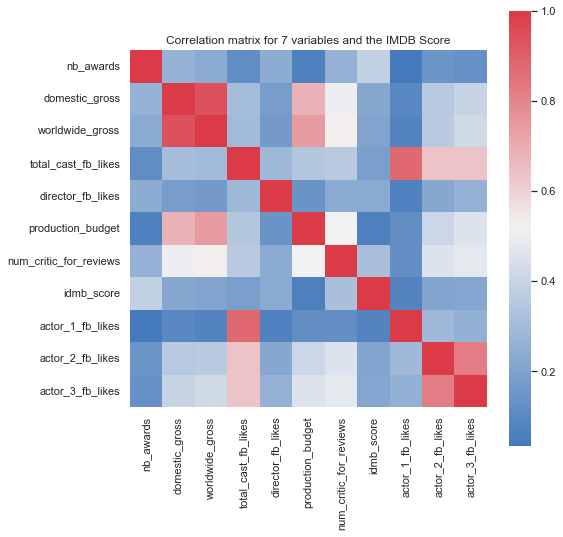

In [61]:
# Correlation Matrix

corr = df[['nb_awards', 'domestic_gross','worldwide_gross', 
    'total_cast_fb_likes','director_fb_likes', 'production_budget',
    'num_critic_for_reviews', 'idmb_score', 'actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),
            square=True)
plt.title('Correlation matrix for 7 variables and the IMDB Score')
corr

## Genres

In [62]:
with open('genre.json', 'r') as f:
    genres = json.load(f)

In [63]:
imdb_score_per_genre = {}
gross_per_genre = {}
genre_columns = [col for col in df.columns if 'genre_' in col]
df_genres = df[genre_columns]
for genre, value in genres.items():
    mask = np.column_stack([df_genres[col] == value for col in df_genres])
    df_specific_genre = df.loc[mask.any(axis=1)][['genres', 'idmb_score', 'worldwide_gross']]
    imdb_score_per_genre[genre] = df_specific_genre.idmb_score.mean()
    gross_per_genre[genre] = df_specific_genre.worldwide_gross.mean()
gross_per_genre = {k:v for k,v in gross_per_genre.items() if pd.notnull(v)}

In [64]:
top_k = 5
print('The {} best genres (in terms of IMDB score) are : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], round(elem[1], 1)) for elem in sorted(imdb_score_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

print('\nThe {} most prolific genres are  : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], millify(elem[1])) for elem in sorted(gross_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

The 5 best genres (in terms of IMDB score) are : 
Biography (7.2)
History (7.0)
Mystery (7.0)
Drama (7.0)
War (7.0)

The 5 most prolific genres are  : 
Adventure (457.0 M)
Fantasy (456.4 M)
Animation (441.1 M)
Sci-Fi (431.4 M)
Musical (425.0 M)


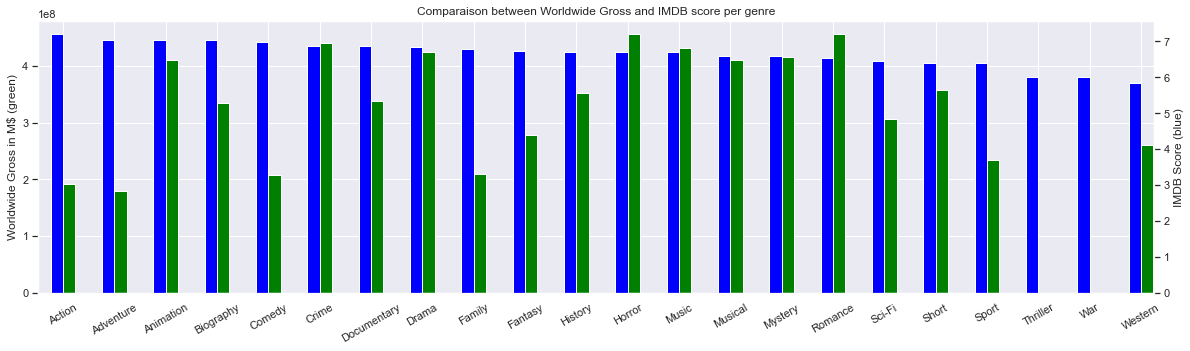

In [65]:
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_combine = pd.concat([pd.Series(gross_per_genre), pd.Series(imdb_score_per_genre)], axis=1)
df_combine = df_combine.sort_values(1, ascending=False)
df_combine.columns = ['Gross', 'Score']

df_combine.Gross.plot(kind='bar', color='green', ax=ax, width=width, position=0)
df_combine.Score.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross in M$ (green)')
ax2.set_ylabel('IMDB Score (blue)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and IMDB score per genre')
_ = ax.set_xticklabels(pd.Series(imdb_score_per_genre).index, rotation = 30)
ax2.grid(False)

## Prediction

### Preprocessing

In [77]:
## Fill NA for genres
df.genres  = df.genres.fillna('')

## Mean Inputer
col_to_impute = ['actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes',
                'domestic_gross', 'duration_sec', 'num_critic_for_reviews', 'num_facebook_like', 'num_user_for_reviews',
                'production_budget', 'total_cast_fb_likes', 'worldwide_gross', 'director_fb_likes']
for col in col_to_impute:
    column = np.array(df[col]).reshape(-1, 1)
    
    
    imp = SimpleImputer(missing_values=np.nan, strategy = 'mean')
    
    df[col] = imp.fit_transform(column)
    

In [78]:
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)
not_wanted_cols = ['title_year', 'storyline', 'release_date', 'image_urls', 'movie_title', 'keywords', 'movie_imdb_link', 'num_voted_users'] + genre_columns
df.country = df.country.apply(lambda x:x.split('|'))
df.language = df.language.apply(lambda x:x.split('|'))
list_cols = ['country', 'genres', 'language']
cols_to_transform = [cols for cols in df.columns if cols not in numerical_cols + not_wanted_cols + list_cols]
df2 = df[cols_to_transform]

In [79]:
## Dummies for columns with list
df_col_list = pd.DataFrame()
for col in list_cols:
    df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)

C:\Users\ROHITB~1\AppData\Local\Temp/ipykernel_9944/4242683464.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)


In [80]:
## Dummies for columns with string
df_col_string = pd.get_dummies(df2, columns=cols_to_transform)

In [81]:
X_raw = pd.concat([df[numerical_cols], df_col_string, df_col_list], axis=1)
print('Columns dtypes :', Counter(X_raw.dtypes))

Columns dtypes : Counter({dtype('uint8'): 13004, dtype('float64'): 13, dtype('int64'): 1})


In [82]:
y = list(X_raw.idmb_score)
X = X_raw.drop('idmb_score', axis=1)

In [85]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Train', X_train.shape, 'Test', X_test.shape)

Train (4089, 13017) Test (1023, 13017)


### Choosing ML algorithm

In [86]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train,Y_train)
print ("Training Score GradientBoosting: ", str(gbr.score(X_train,Y_train)))
print ("Test Score GradientBoosting: " , str(gbr.score(X_test,Y_test)))

Training Score GradientBoosting:  0.7782270281536336
Test Score GradientBoosting:  0.43527082475490986


In [130]:
abr = ensemble.AdaBoostRegressor(n_estimators=10, learning_rate=0.4, loss='linear')
abr.fit(X_train,Y_train)
print ("Training Score AdaBoostRegressor: ", str(abr.score(X_train,Y_train)))
print ("Test Score AdaBoostRegressor: " , str(abr.score(X_test,Y_test)))
print(abr.predict(np.array(X_train.loc["The Shawshank Redemption", :]).reshape(1, -1)))
print(abr.predict(np.array(X_test.iloc[2, :]).reshape(1, -1)))


Training Score AdaBoostRegressor:  0.35273836578379947
Test Score AdaBoostRegressor:  0.34291062796821203
[7.85719557]
[5.64637596]


C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(
C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostRegressor was fitted with feature names
  warnings.warn(


In [121]:
X_test.head()

,duration_sec,num_critic_for_reviews,num_facebook_like,num_user_for_reviews,director_fb_likes,total_cast_fb_likes,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes,worldwide_gross,...,Turkish,Ukrainian,Urdu,Vietnamese,Washoe,Welsh,Wolof,Xhosa,Yiddish,Zulu
movie_title,,,,,,,,,,,,,,,,,,,,,
Poseidon,5880.0,230.0,1800.0,630.0,256.0,103969.000000,87000.000000,3600.000000,3500.000000,181674817.0,...,0,0,0,0,0,0,0,0,0,0
Mommy,8340.0,245.0,13000.0,45.0,1700.0,28471.711884,11391.675942,5011.650232,3112.732403,17561100.0,...,0,0,0,0,0,0,0,0,0,0
Ice Age: The Meltdown,5460.0,163.0,1500.0,254.0,110.0,28471.711884,11391.675942,5011.650232,3112.732403,651899282.0,...,0,0,0,0,0,0,0,0,0,0
The Perfect Host,5580.0,110.0,6500.0,76.0,11.0,1667.000000,454.000000,401.000000,277.000000,51587.0,...,0,0,0,0,0,0,0,0,0,0
The Client,7140.0,42.0,1000.0,94.0,558.0,21962.000000,7900.000000,2600.000000,2500.000000,117615211.0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
rf=ensemble.RandomForestRegressor(n_estimators=500,oob_score=True, ) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("Cross Validation (10 fold) Score: " , np.mean(cross_val_score(rf, X_train, Y_train, cv=10)))


Training Score RandomForest:  0.9290263916611343
Cross Validation (10 fold) Score:  0.4700534928879184


### Tuning

#### Cross Validation to choose n_estimators

In [89]:
rfs = {}
for k in [10, 20, 50, 70, 100, 120, 150, 200]:
    rf=ensemble.RandomForestRegressor(n_estimators=k, oob_score=True) 
    rf.fit(X,y)
    rfs[k] = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))

C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Rohit Bhadauria\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Rohit Bhada

Text(0, 0.5, 'Cross Validation score')

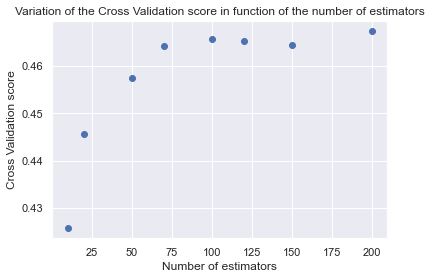

In [90]:
x_plot = list(rfs.keys())
y_plot = list(rfs.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the number of estimators')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

#### Min leaf

In [91]:
rfs2 = {}
for k in tqdm(list(range(1, 11, 2))+list(range(11,25,4))):
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf=k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

100%|██████████| 9/9 [15:45<00:00, 105.08s/it]


Text(0, 0.5, 'OOB score')

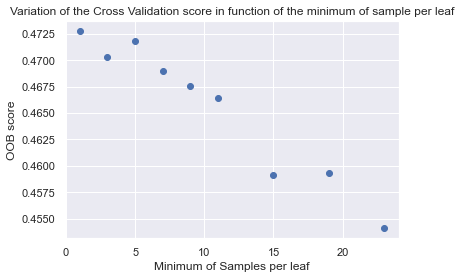

In [92]:
x_plot = list(rfs2.keys())
y_plot = list(rfs2.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Minimum of Samples per leaf')
ax.set_ylabel('OOB score')

#### max_features

In [93]:
rfs2 = {}
for k in ["log2", "auto", "sqrt", 0.2, 0.1, 0.3] :
    rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, min_samples_leaf= 1, max_features = k) 
    rf.fit(X,y)
    rfs2[k] = rf.oob_score_

['log2', 'auto', 'sqrt', 0.2, 0.1, 0.3]


Text(0, 0.5, 'Cross Validation score')

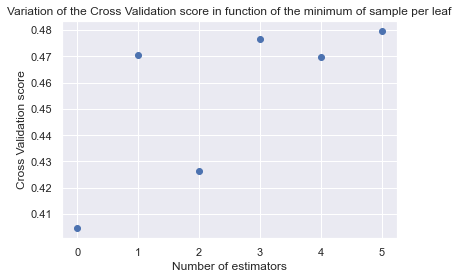

In [94]:
x_plot = range(len(rfs2))# list(rfs2.keys())
y_plot = list(rfs2.values())
print(list(rfs2.keys()))
f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the minimum of sample per leaf')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

### Learning

In [95]:
rf = ensemble.RandomForestRegressor(n_estimators=120, oob_score=True, max_features=0.2, min_samples_leaf=5) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("OOB Score RandomForest: " , str(rf.oob_score_))

Training Score RandomForest:  0.6772679737024274
OOB Score RandomForest:  0.4687997842327625


### Most important features

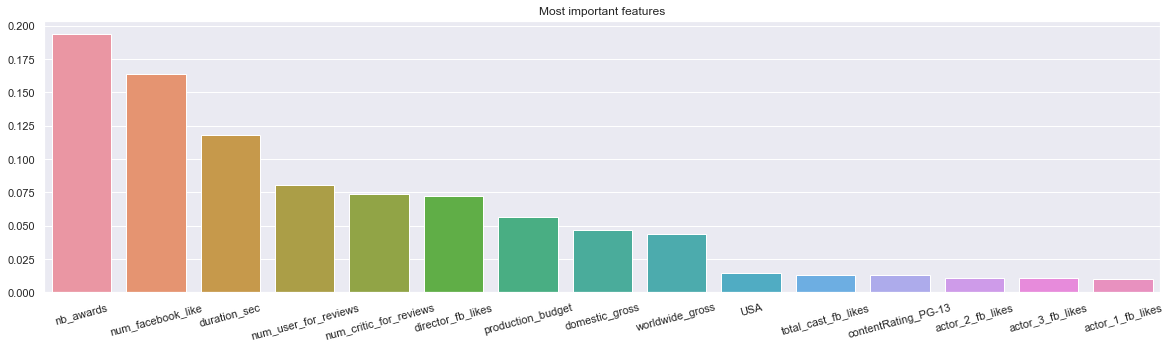

In [96]:
top_k = 15
plt.figure(figsize=(20,5))
names = X_train.columns[np.argsort(rf.feature_importances_)[::-1][:top_k]]
values = np.sort(rf.feature_importances_)[::-1][:top_k]
plot = sns.barplot(x = names, y = values, order=names)
_ = plot.set_xticklabels(names, rotation=15)
_ = plot.set_title('Most important features')